In [1]:
# (C) Copyright IBM Corp. 2019, 2020, 2021, 2022.

#    Licensed under the Apache License, Version 2.0 (the "License");
#    you may not use this file except in compliance with the License.
#    You may obtain a copy of the License at

#           http://www.apache.org/licenses/LICENSE-2.0

#     Unless required by applicable law or agreed to in writing, software
#     distributed under the License is distributed on an "AS IS" BASIS,
#     WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#     See the License for the specific language governing permissions and
#     limitations under the License.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from simulai.regression import DenseNetwork, ModalRBFNetwork
from simulai.optimization import Optimizer
from simulai.residuals import SymbolicOperator
from simulai.file import SPFile

#### Our PDE:
#### Allen-Cahn equation.

In [3]:
f = 'D(u, t) - mu*D(D(u, x), x) + alpha*(u**3) + beta*u'

g_u = 'u'
g_ux = 'D(u, x)'

input_labels = ['x', 't']
output_labels = ['u']

#### Some fixed values.

In [4]:
X_DIM = 256
T_DIM = 100

L = 1
x_0 = -1
T = 1

#### Generating the training grid.

In [5]:
x_interval = [x_0, L]
t_interval = [0, T]

intervals = [x_interval, t_interval]

intv_array = np.vstack(intervals).T

# Regular grid
x_0, x_L = x_interval
t_0, t_L = t_interval
dx = (x_L - x_0) / X_DIM
dt = (t_L - t_0) / T_DIM

grid = np.mgrid[t_0+dt:t_L+dt:dt, x_0:x_L:dx]

data = np.hstack([grid[1].flatten()[:, None],
                  grid[0].flatten()[:, None]])

data_init = np.linspace(*x_interval, X_DIM)
u_init = (data_init**2)*np.cos(np.pi * data_init)[:, None]

# Boundary grids
data_boundary_x0 = np.hstack([x_interval[0] * np.ones((T_DIM, 1)),
                              np.linspace(*t_interval, T_DIM)[:, None]])

data_boundary_xL = np.hstack([x_interval[-1] * np.ones((T_DIM, 1)),
                              np.linspace(*t_interval, T_DIM)[:, None]])

data_boundary_t0 = np.hstack([np.linspace(*x_interval, X_DIM)[:, None],
                              t_interval[0] * np.ones((X_DIM, 1))])

#### Visualizing the grid domain.

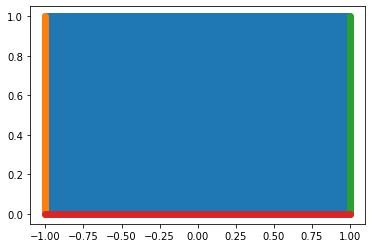

In [6]:
plt.scatter(*np.split(data, 2, axis=1))
plt.scatter(*np.split(data_boundary_x0, 2, axis=1))
plt.scatter(*np.split(data_boundary_xL, 2, axis=1))
plt.scatter(*np.split(data_boundary_t0, 2, axis=1))

plt.show()
plt.close()

In [7]:
#### Model template.

In [8]:
def model():

    from simulai.regression import DenseNetwork
    
    n_inputs = len(input_labels)
    n_outputs = len(output_labels)

    # Configuration for the fully-connected network
    config = {
                'layers_units': [128, 128, 128, 128],
                'activations': 'tanh',
                'input_size': n_inputs,
                'output_size': n_outputs,
                'name': 'allen_cahn_net'
             }

    # Instantiating and training the surrogate model
    net = DenseNetwork(**config)

    return net

#### Intantiating neural net.

In [9]:
net = model()
net.summary()

Summary of the network properties:
Linear operations layers:

[ Linear(in_features=2, out_features=128, bias=True),
  Linear(in_features=128, out_features=128, bias=True),
  Linear(in_features=128, out_features=128, bias=True),
  Linear(in_features=128, out_features=128, bias=True),
  Linear(in_features=128, out_features=1, bias=True)]


Activations layers:

['tanh', 'tanh', 'tanh', 'tanh', 'identity']


Initializations at each layer:

['xavier', 'xavier', 'xavier', 'xavier', 'xavier']


#### Constructor for the PINN symbolic residual.

In [10]:
residual = SymbolicOperator(expressions=[f], input_vars=input_labels,
                            auxiliary_expressions={'periodic_u': g_u, 'periodic_du': g_ux},
                            constants={'mu':1e-4, 'alpha':5, 'beta':-5},
                            output_vars=output_labels, function=net,
                            engine='torch',
                            device='gpu')

#### Configuring optimizer.

In [11]:
n_epochs = 50_000  # Maximum number of iterations for ADAM
lr = 1e-3  # Initial learning rate for the ADAM algorithm

optimizer_config = {'lr': lr}


optimizer = Optimizer('adam', params=optimizer_config,
                      lr_decay_scheduler_params={'name': 'ExponentialLR',
                                                         'gamma': 0.9,
                                                         'decay_frequency': 5_000},
                      shuffle=False,
                      summary_writer=True)

params = {'residual': residual,
          'initial_input': data_boundary_t0,
          'initial_state': u_init,
          'boundary_input': {'periodic_u': [data_boundary_xL, data_boundary_x0],
                             'periodic_du': [data_boundary_xL, data_boundary_x0]},
          'boundary_penalties': [1, 1],
          'initial_penalty': 100}

Optimizer adam found in <module 'torch.optim' from '/home/jalmeida/.conda/envs/torchsimulaienv/lib/python3.9/site-packages/torch/optim/__init__.py'>.


#### Executing training.

In [12]:
optimizer.fit(op=net, input_data=data,
              n_epochs=n_epochs, loss="pirmse", params=params, device='gpu')

Using LR decay <class 'torch.optim.lr_scheduler.ExponentialLR'>.
pde: 1.3501198291778564, init: 0.2679139971733093, bound: 4.159900665283203 , causality_weights: (1e-25, 0))

#### Saving trained model.

In [13]:
saver = SPFile(compact=False)
saver.write(save_dir='.', name='allen_cahn_net', model=net, template=model)

#### Generating results using the trained model.

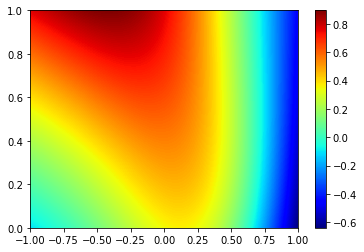

In [14]:
# Evaluation and post-processing
X_DIM_F = 5 * X_DIM
T_DIM_F = 5 * T_DIM

x_f = np.linspace(*x_interval, X_DIM_F)
t_f = np.linspace(*t_interval, T_DIM_F)

T_f, X_f = np.meshgrid(t_f, x_f, indexing='ij')

data_f = np.hstack([X_f.flatten()[:, None],
                    T_f.flatten()[:, None]])

# Evaluation in training dataset
approximated_data = net.cpu().eval(input_data=data_f)

U_f = approximated_data.reshape(T_DIM_F, X_DIM_F)

fig, ax = plt.subplots()
ax.set_aspect('auto')
gf = ax.pcolormesh(X_f, T_f, U_f, cmap='jet')
fig.colorbar(gf)